On commence par un modèle Naif: On prévoit à J+7(8) la valeur moyenne de l'ensemble d'entrainement.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [3]:
%run Eval_fcts.py
%run Standardize_fcts.py

## Score de Validation croisée.

In [4]:
cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})
    
cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})

for curr_split in tqdm(range(9)):
    
    curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
    curr_train_X_mean = curr_train_X[liste_stations_debit].mean()
    curr_train_X_std = curr_train_X[liste_stations_debit].std()
    curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
    curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
    liste_dates = curr_test_Y["Date"]
    
    predictions_Y = pd.DataFrame({"Date": list(liste_dates)})
    predictions_Y[liste_stations_debit] = curr_train_X_mean[liste_stations_debit]
    
    curr_test_Y_standard = fct_Standardize(curr_test_Y,
                                             curr_train_X_mean, curr_train_X_std,
                                             liste_stations_debit)
    curr_test_Y_standard["Date"] = curr_test_Y["Date"]
    predictions_Y_standard = fct_Standardize(predictions_Y,
                                             curr_train_X_mean, curr_train_X_std,
                                             liste_stations_debit)
    predictions_Y_standard["Date"] = predictions_Y["Date"]

    # Scores
    curr_scores_RMSE = fct_RMSE(curr_test_Y, predictions_Y, liste_stations_debit)
    cv_scores_RMSE["Split_" + str(curr_split)] = curr_scores_RMSE["RMSE"]
    curr_scores_MAE = fct_MAE(curr_test_Y, predictions_Y, liste_stations_debit)
    cv_scores_MAE["Split_" + str(curr_split)] = curr_scores_MAE["MAE"]
    curr_scores_R2 = fct_R2(curr_test_Y, predictions_Y, liste_stations_debit)
    cv_scores_R2["Split_" + str(curr_split)] = curr_scores_R2["R2"]
    # Scores standards
    curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
    cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
    curr_MAE = fct_MAE(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
    cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
    curr_R2 = fct_R2(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
    cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]

100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  4.78it/s]


In [6]:
cv_moyen_RMSE_standard = []
cv_moyen_MAE_standard = []
cv_moyen_R2_standard = []
    
cv_moyen_RMSE = []
cv_moyen_MAE = []
cv_moyen_R2 = []

for code in liste_stations_debit:
    score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_RMSE_standard.append(score_RMSE)
    score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_MAE_standard.append(score_MAE)
    score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_R2_standard.append(score_R2)
    score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_RMSE.append(score_RMSE)
    score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_MAE.append(score_MAE)
    score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_R2.append(score_R2)

cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
cv_scores_RMSE_standard.to_csv("../Data/Moyenne/CV_RMSE_standard.csv",
                          index=False)
cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
cv_scores_MAE_standard.to_csv("../Data/Moyenne/CV_MAE_standard.csv",
                          index=False)
cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
cv_scores_R2_standard.to_csv("../Data/Moyenne/CV_R2_standard.csv",
                          index=False)
cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
cv_scores_RMSE.to_csv("../Data/Moyenne/CV_RMSE.csv",
                          index=False)
cv_scores_MAE["Moyenne"] = cv_moyen_MAE
cv_scores_MAE.to_csv("../Data/Moyenne/CV_MAE.csv",
                          index=False)
cv_scores_R2["Moyenne"] = cv_moyen_R2
cv_scores_R2.to_csv("../Data/Moyenne/CV_R2.csv",
                          index=False)

<AxesSubplot:ylabel='Density'>

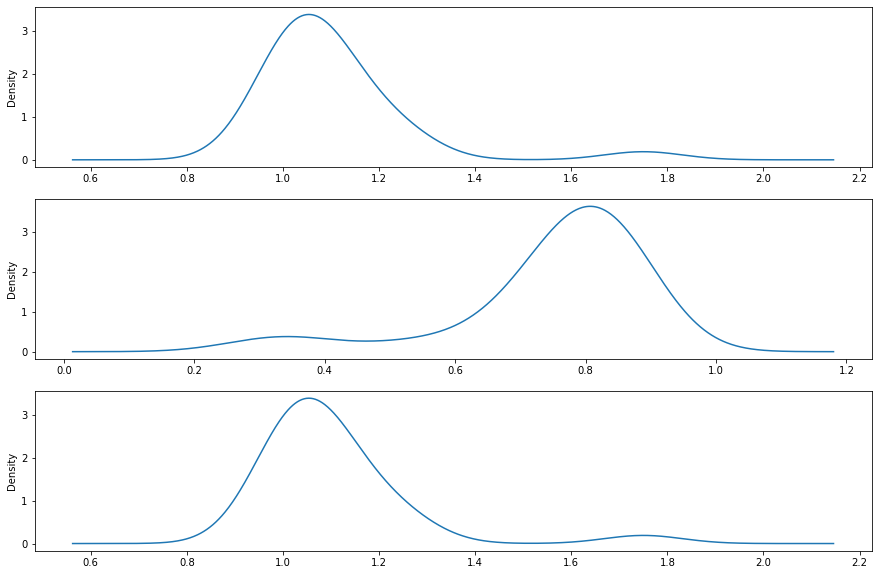

In [7]:
fig, axs = plt.subplots(3, 1, figsize = (15,10))
cv_scores_RMSE_standard["Moyenne"].plot.density(ax = axs[0])
cv_scores_MAE_standard["Moyenne"].plot.density(ax = axs[1])
cv_scores_RMSE_standard["Moyenne"].plot.density(ax = axs[2])

### Scores standards moyens

In [8]:
cv_moyen = pd.read_csv("../Data/Moyenne/CV_RMSE_standard.csv")["Moyenne"]
cv_moyen.mean()

1.1025847379049594

In [9]:
cv_moyen = pd.read_csv("../Data/Moyenne/CV_MAE_standard.csv")["Moyenne"]
cv_moyen.mean()

0.7508032412587434

In [10]:
cv_moyen = pd.read_csv("../Data/Moyenne/CV_R2_standard.csv")["Moyenne"]
cv_moyen.mean()

0.0

# Score sur l'ensemble de test

In [11]:
liste_dates = mesures_test_Y["Date"]
mesures_train_X_mean = mesures_train_X[liste_stations_debit].mean()
mesures_train_X_std = mesures_train_X[liste_stations_debit].std()

predictions_test_Y = pd.DataFrame({"Date": list(liste_dates)})
predictions_test_Y[liste_stations_debit] = mesures_train_X_mean[liste_stations_debit]

mesures_test_Y_standard = fct_Standardize(mesures_test_Y,
                                          mesures_train_X_mean, mesures_train_X_std,
                                             liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]
predictions_test_Y_standard = fct_Standardize(predictions_test_Y,
                                             mesures_train_X_mean, mesures_train_X_std,
                                             liste_stations_debit)
predictions_test_Y_standard["Date"] = predictions_test_Y["Date"]

In [12]:
scores_RMSE = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_MAE = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_R2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_RMSE["RMSE"],
                            "MAE": scores_MAE["MAE"],
                            "R2": scores_R2["R2"]})
test_scores.to_csv("../Data/Moyenne/Test_scores.csv",
                   index=False)
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,31.619737,25.202347,5.049681e-32
1,O2620010,156.601153,102.168581,3.293901e-32
2,O6140010,306.006613,203.915105,3.450633e-32
3,O9000010,485.914296,312.170538,5.473952e-32
4,K0030020,4.324613,1.134748,2.636246e-33
5,K0100020,6.614763,3.087746,0.000000e+00
6,K0260020,20.164911,7.993766,3.104043e-32
7,K0550010,40.406282,20.059612,6.957691e-32
8,K0690010,50.255493,30.856363,7.996010e-32
9,K0910050,53.045489,36.899619,0.000000e+00


In [13]:
scores_RMSE_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_MAE_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_R2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_RMSE_standard["RMSE"],
                            "MAE": scores_MAE_standard["MAE"],
                            "R2": scores_R2_standard["R2"]})
test_scores_standard.to_csv("../Data/Moyenne/Test_scores_standard.csv",
                   index=False)
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.666837,0.531499,0.0
1,O2620010,0.764634,0.498857,0.0
2,O6140010,0.916649,0.610832,0.0
3,O9000010,0.990838,0.636553,0.0
4,K0030020,0.589088,0.154573,0.0
5,K0100020,0.605957,0.282859,0.0
6,K0260020,0.967583,0.383569,0.0
7,K0550010,1.040578,0.516593,0.0
8,K0690010,1.060893,0.651377,0.0
9,K0910050,0.886087,0.616382,0.0


In [14]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.840853
MAE     0.615114
R2      0.000000
dtype: float64

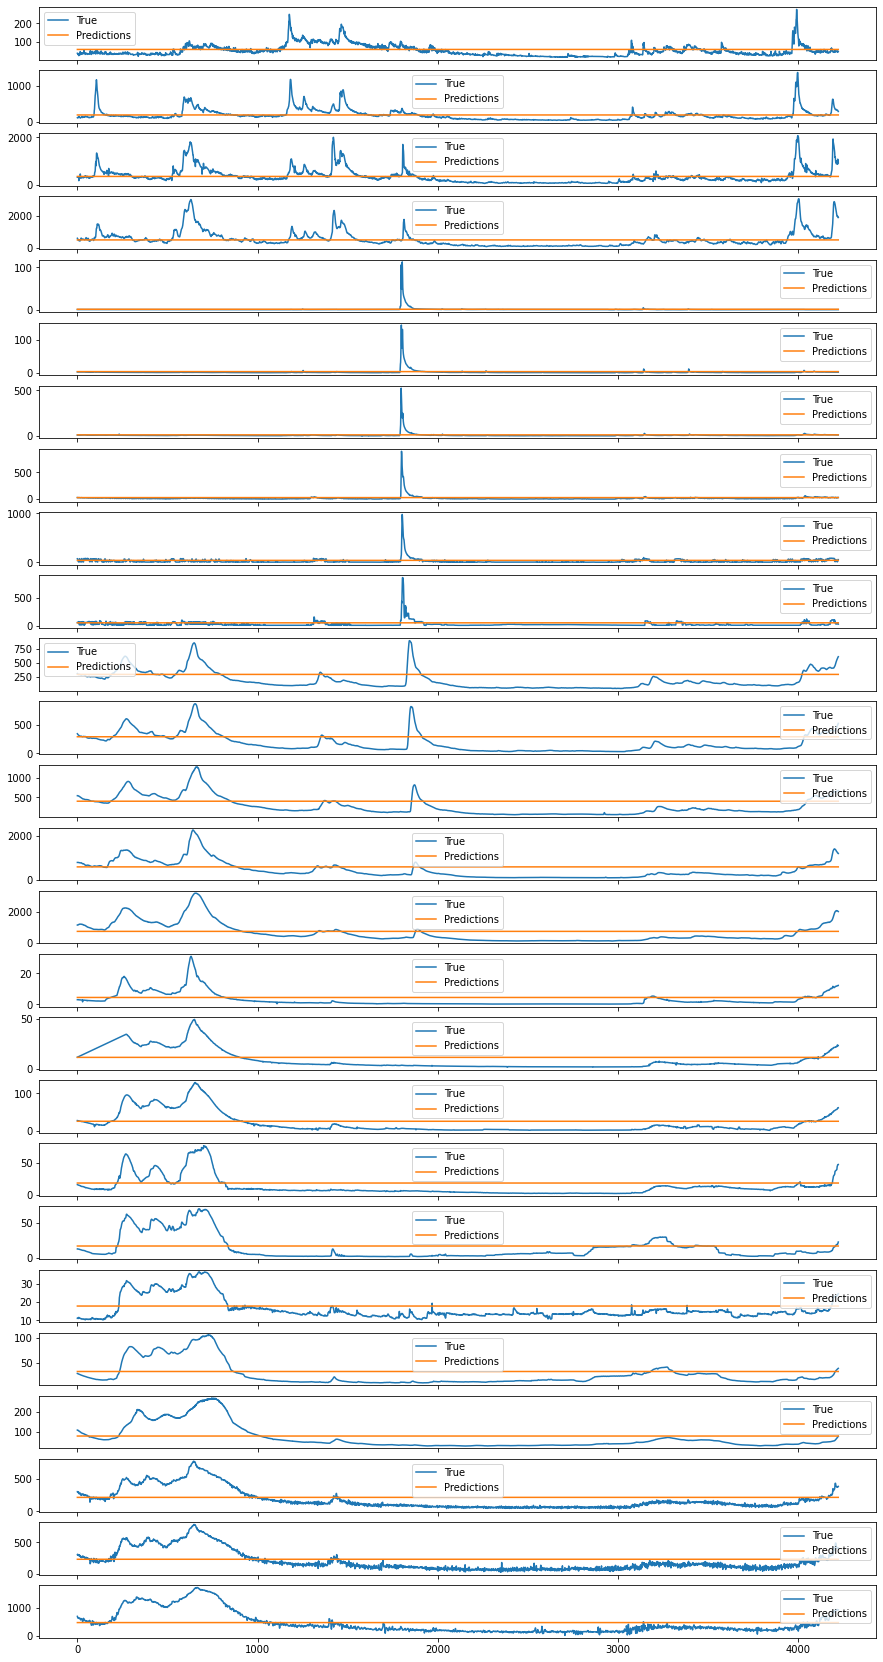

In [15]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

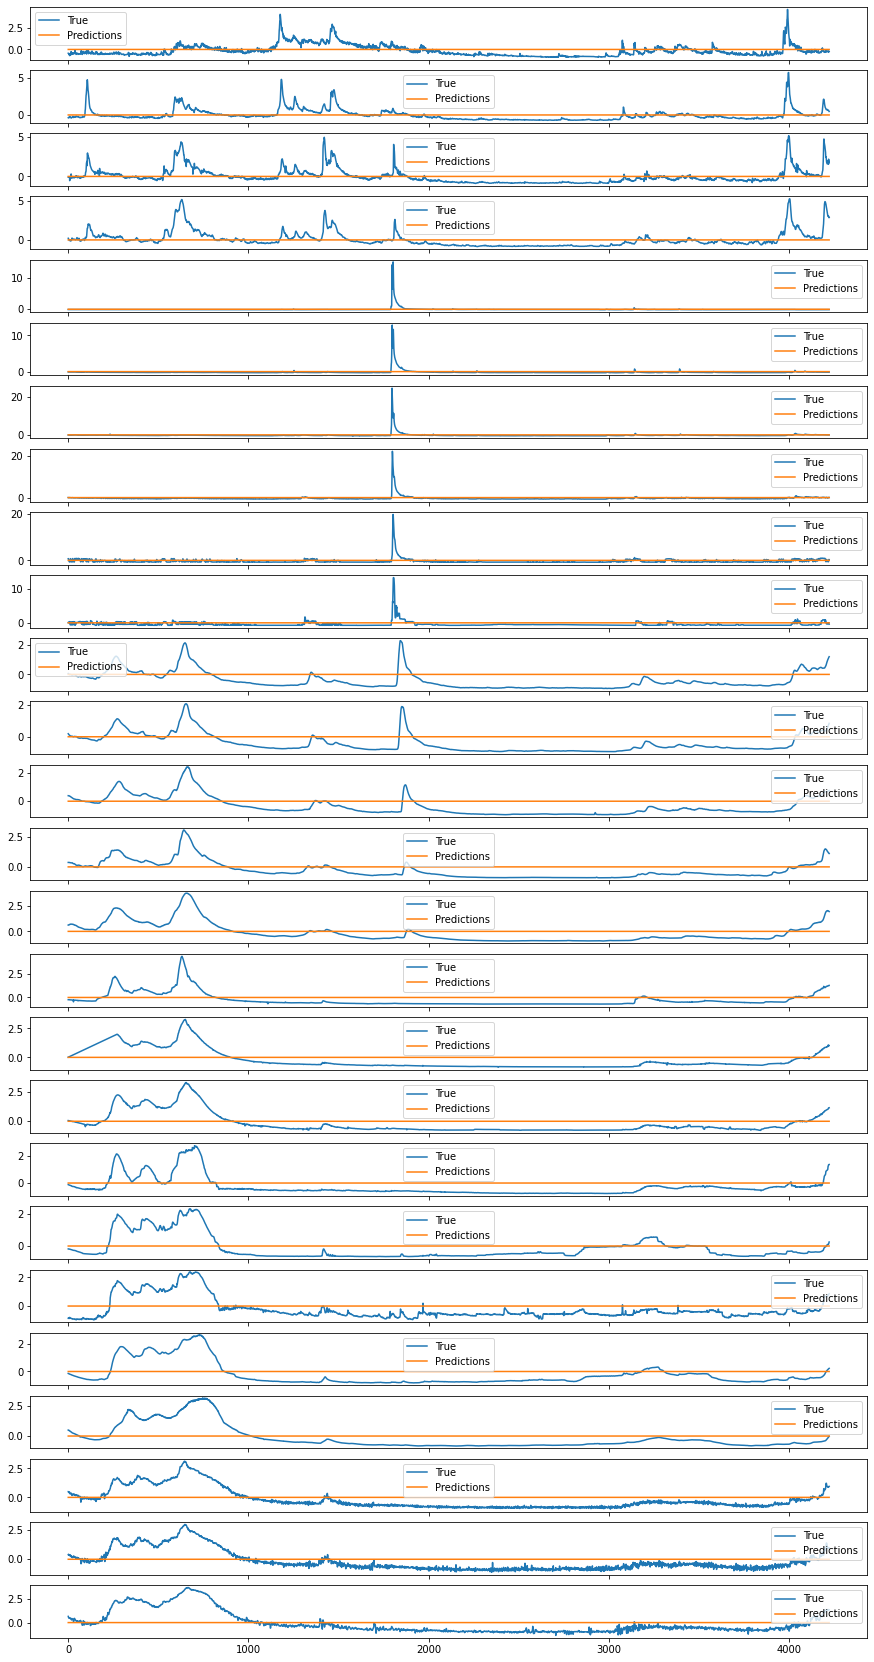

In [16]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()